In [1]:
import pandas as pd
import numpy as np
import h5py

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn.metrics import v_measure_score

from scipy.stats import spearmanr

   
def calculate_pvalues(df,
                      method = spearmanr
                     ):
    """
    Assumes df with only numeric entries clean of null entries. 
    """
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(method(df[r], df[c])[1], 4)
    return pvalues
    
    
def correlation_matrix(df,
                       method = "pearson",
                       annot_bool = False,
                       annot_size = 20
                      ):
    # Compute the correlation matrix
    corr = df.corr(method = method)

    if annot_bool:
        annot = corr.copy()
        
        if method == "pearson":
            sig_meth = pearsonr
        elif hasattr(method, "__call__"):
            sig_meth = method
        else:
            sig_meth = spearmanr
            
        pval = calculate_pvalues(df, sig_meth) 
        # create three masks
        r0 = corr.applymap(lambda x: '{:.2f}'.format(x))
        r1 = corr.applymap(lambda x: '{:.2f}*'.format(x))
        r2 = corr.applymap(lambda x: '{:.2f}**'.format(x))
        r3 = corr.applymap(lambda x: '{:.2f}***'.format(x))
  
        # apply them where appropriate --this could be a single liner
        annot = annot.where(pval>0.1,r0)
        annot = annot.where(pval<=0.1,r1)
        annot = annot.where(pval<=0.05,r2)
        annot = annot.mask(pval<=0.01,r3)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 11))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    
    if annot_bool == True:
        sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},
                    annot = annot,
                    fmt = "",
                    annot_kws={"size": annot_size},
                    vmin = -1,
                    vmax = 1,
                   )
    else: 
        sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            vmin = -1,
            vmax = 1,
                   )
        
    return f, ax, corr
    

In [2]:
test_targets = None
train_targets = None

with h5py.File("../data/images.h5", "r") as fo:
    train_targets = np.array(fo["train_targets"])
    test_targets = np.array(fo["test_targets"])

In [3]:
train_latent = np.load("../drawing/latent/train_latent.npy")
test_latent = np.load("../drawing/latent/test_latent.npy")

In [4]:
n_train = train_latent.shape[0]
n_test = test_latent.shape[0]

train_targets = train_targets[:n_train]
test_targets = test_targets[:n_test]

In [5]:
where_zero = np.where(train_targets == 0)
where_one = np.where(train_targets == 1)
where_two = np.where(train_targets == 2)

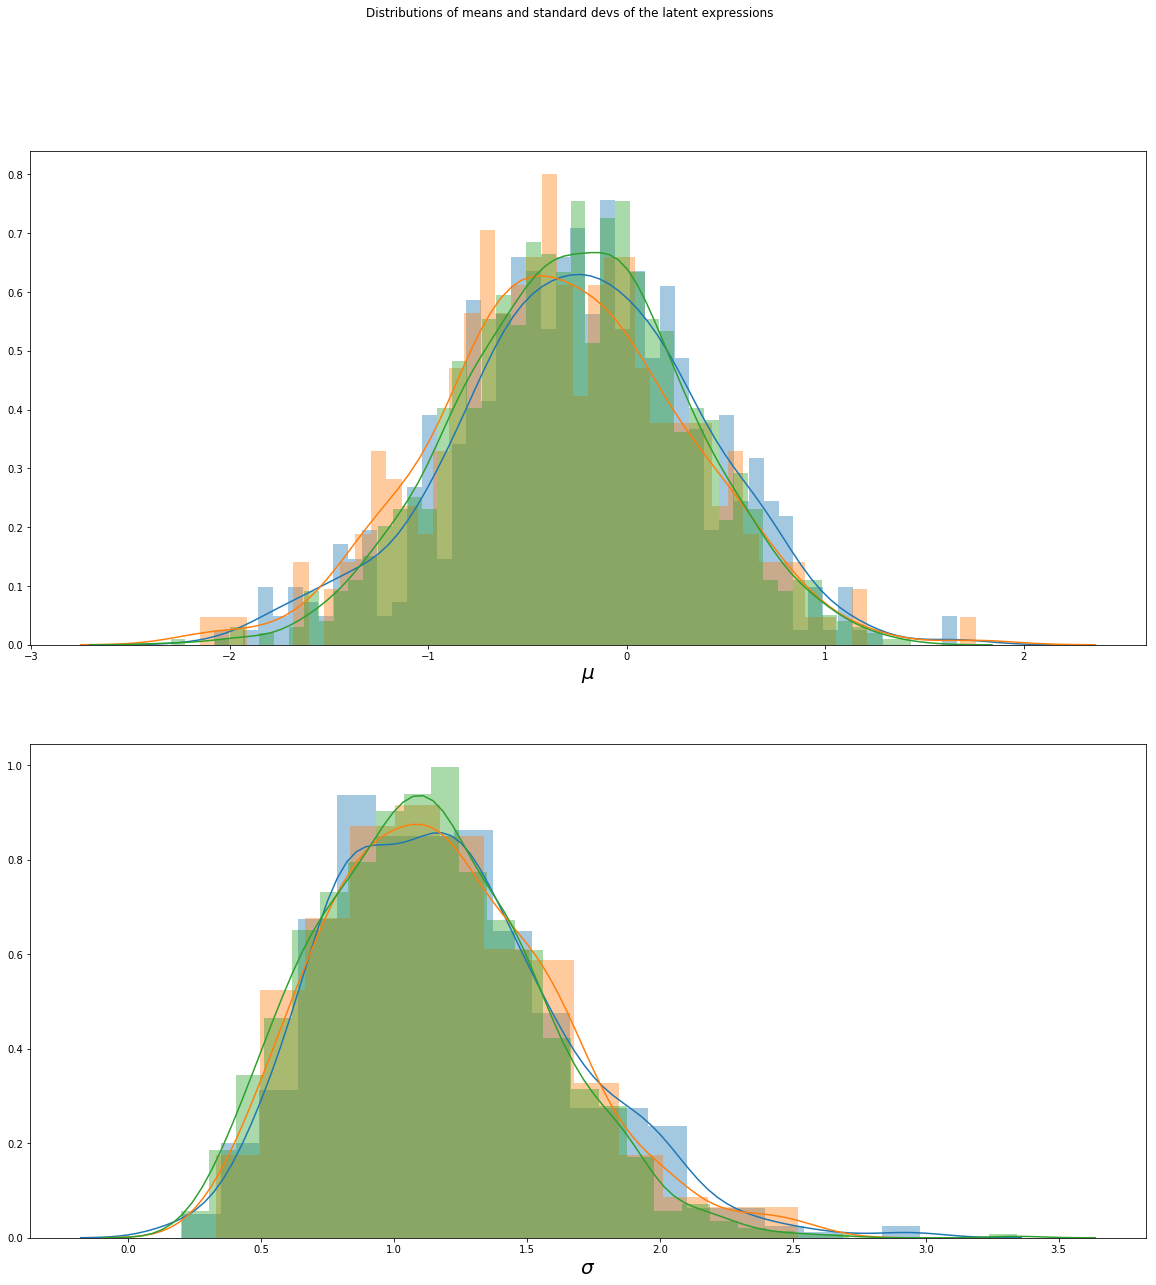

In [6]:
means_zero = np.average(train_latent[where_zero], axis = 1)
means_one = np.average(train_latent[where_one], axis = 1)
means_two = np.average(train_latent[where_two], axis = 1)

means = [means_zero, means_one, means_two]

stds_zero = np.std(train_latent[where_zero], axis = 1)
stds_one = np.std(train_latent[where_one], axis = 1)
stds_two = np.std(train_latent[where_two], axis = 1)

stds = [stds_zero, stds_one, stds_two]

fig, axs = plt.subplots(nrows = 2, figsize = (20, 20))
fig.suptitle("Distributions of means and standard devs of the latent expressions")

for mean in means:
    sns.distplot(mean, ax=axs[0], norm_hist=False, bins = 50)
    #axs[0].plot([np.average(mean)]*2, [0, 1.0], "r", label=r"mean $\mu$")
    axs[0].set_xlabel(r"$\mu$", size = 20)

for std in stds:
    sns.distplot(std, ax=axs[1], norm_hist=False)
    #axs[1].plot([np.average(stds)]*2, [0, 1.4], "r", label=r"mean $\sigma$")
    axs[1].set_xlabel(r"$\sigma$", size = 20)
    

In [7]:
n_zero = sum(train_targets == 0)
n_one = sum(train_targets == 1)
n_two = sum(train_targets == 2)

print("Distribution of classes")
print("% in 0 class: ", 100*(n_zero/n_train))
print("% in 1 class: ", 100*(n_one/n_train))
print("% in 2 class: ", 100*(n_two/n_train))

Distribution of classes
% in 0 class:  25.441860465116278
% in 1 class:  12.651162790697674
% in 2 class:  61.906976744186046


In [8]:
print(train_latent.shape)

(2150, 5)


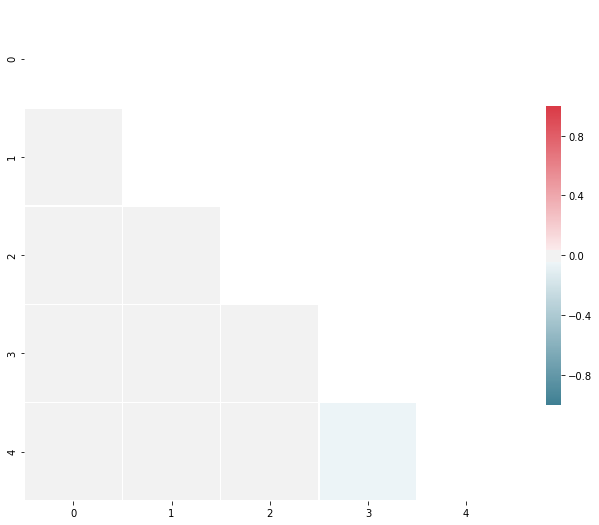

In [9]:
latent_df = pd.DataFrame(train_latent)
_, _, corr = correlation_matrix(latent_df, method="spearman")

In [10]:
lambdas, eig_vecs = np.linalg.eig(corr)

In [11]:
lambdas

array([0.91909664, 0.97457743, 1.05997923, 1.02704427, 1.01930243])

In [12]:
complete_df = pd.DataFrame(train_latent)
complete_df["targets"] = train_targets

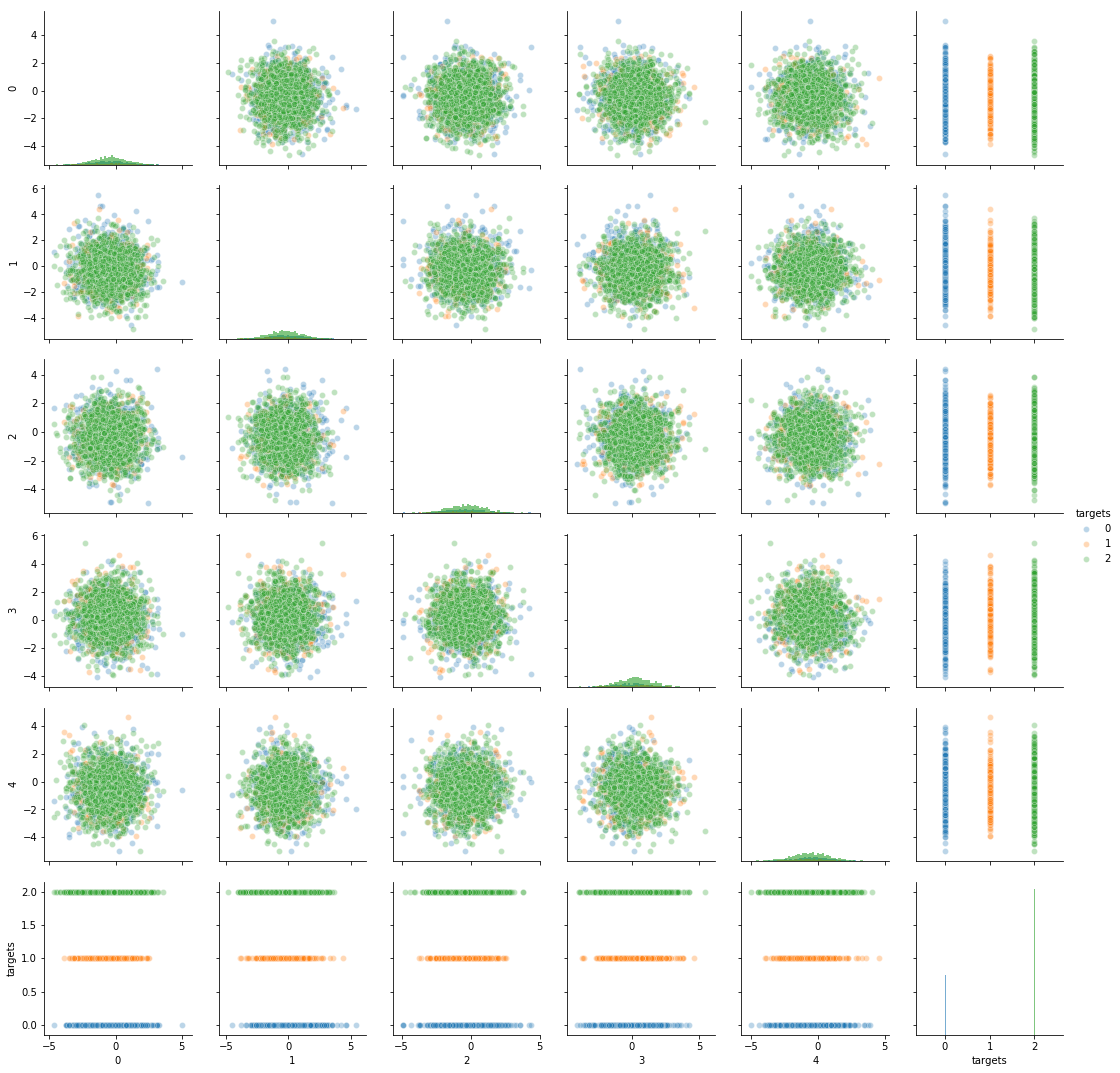

In [13]:
g = sns.pairplot(
    complete_df, 
    hue="targets",
    diag_kind="hist",
    plot_kws={"alpha":0.3},
    diag_kws={"alpha":0.6, "bins": 50}
                )

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, confusion_matrix

class_weights = {0: 1, 1: 1, 2:0.4}

"""
classifier = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    class_weight=class_weights,
    C=0.2)
"""

classifier = LinearSVC(
    max_iter=10000,
    class_weight=class_weights
    )

classifier.fit(train_latent, train_targets)

y_hat = classifier.predict(test_latent)

print(accuracy_score(test_targets, y_hat))
print(confusion_matrix(test_targets, y_hat))

0.638
[[ 15   0  92]
 [  8   0  55]
 [ 26   0 304]]
